## Efemeridska astronomija - Vežbe 6 - Mesec i pomračenja

**1. Za trenutnog posmatrača u Beogradu odštampati trenutke lokalnog vremena za:**
- **Prethodni i sledeći pun Mesec**
- **Prethodni i sledeći mladi Mesec**
- **Prethodni i sledeći izlazak Meseca**
- **Prethodni i sledeći zalazak Meseca**

Za ovaj zadatak koristimo neke od funkcija koje nam pruža PyEphem, a čija je namena jasna iz koda koji sledi.

In [1]:
import ephem
import datetime

now = datetime.datetime.now()
moon = ephem.Moon()
bg = ephem.Observer()
bg.date = now
bg.lat = "44.8125"
bg.lon = "20.4612"

print("Pun Mesec")
print(f"  Prethodni: {ephem.localtime(ephem.previous_full_moon(now))}")
print(f"  Sledeći:   {ephem.localtime(ephem.next_full_moon(now))}")
print()

print("Mladi Mesec")
print(f"  Prethodni: {ephem.localtime(ephem.previous_new_moon(now))}")
print(f"  Sledeći:   {ephem.localtime(ephem.next_new_moon(now))}")
print()

print("Izlazak Meseca")
print(f"  Prethodni: {ephem.localtime(bg.previous_rising(moon))}")
print(f"  Sledeći:   {ephem.localtime(bg.next_rising(moon))}")
print()

print("Zalazak Meseca")
print(f"  Prethodni: {ephem.localtime(bg.previous_setting(moon))}")
print(f"  Sledeći:   {ephem.localtime(bg.next_setting(moon))}")
print()

Pun Mesec
  Prethodni: 2023-01-07 00:07:52.481055
  Sledeći:   2023-02-05 19:28:31.157832

Mladi Mesec
  Prethodni: 2023-01-21 21:53:13.186580
  Sledeći:   2023-02-20 08:05:47.774042

Izlazak Meseca
  Prethodni: 2023-01-23 08:36:21.505620
  Sledeći:   2023-01-24 09:04:00.555325

Zalazak Meseca
  Prethodni: 2023-01-23 18:35:58.006167
  Sledeći:   2023-01-24 19:58:15.913798



**2. Odrediti položaj Meseca u horizontskom koordinatnom sistemu u naredna 24 časa za svaki sat i prikazati na grafiku.**

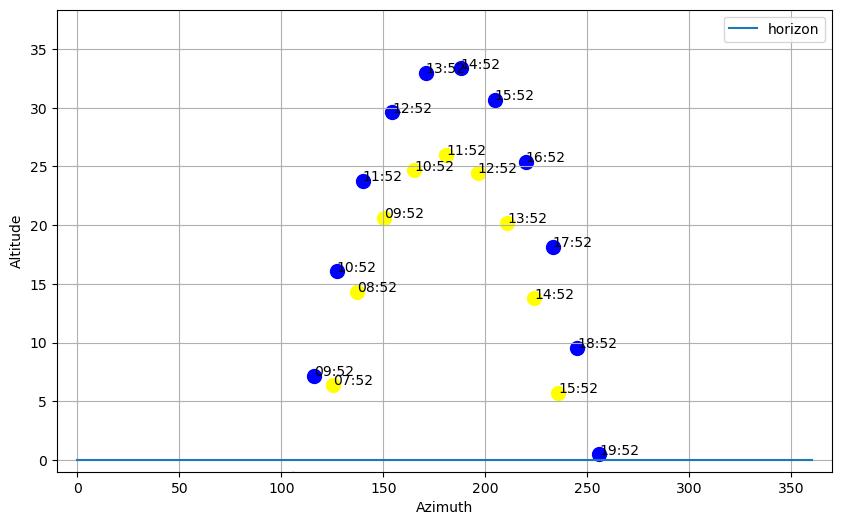

In [2]:
import numpy as np
import matplotlib.pyplot as plt

now = datetime.datetime.now()

def scatter_txt(date, x, y, color):
    txt = ephem.localtime(date).strftime("%H:%M")
    plt.scatter(x, y, 100, color)
    plt.annotate(txt, (x, y))

plt.figure(figsize=(10,6))  
sun = ephem.Sun()
max_x = -90
for i in range(24):
    bg.date = now + datetime.timedelta(hours=i)
    moon.compute(bg)
    scatter_txt(bg.date, np.rad2deg(moon.az), np.rad2deg(moon.alt), "blue")
        
    sun.compute(bg)
    scatter_txt(bg.date, np.rad2deg(sun.az), np.rad2deg(sun.alt), "yellow")

    if np.rad2deg(moon.alt) > max_x:
        max_x = np.rad2deg(moon.alt)
        
    if np.rad2deg(sun.alt) > max_x:
        max_x = np.rad2deg(sun.alt)

plt.xlim([-10, 370])
plt.xlabel("Azimuth")
plt.ylim([-1, max_x+5])
plt.ylabel("Altitude")
plt.plot(np.linspace(0, 360, 10), np.zeros(10), label="horizon")
plt.legend()
plt.grid()
plt.show()

**11. Odrediti koordinate u horizontskom sistemu za Mesec u toku tekućeg meseca i prikazati faze Meseca koristeći se *moon_phase.ttf* fontom (dostupan na [ovom linku]) i pored svake faze ispisati redni broj dana u mesecu.**

Glavni deo ovog zadatka je određivanje trenutne faze Meseca, jer PyEphem ne poseduje te informacije, pa ih moramo odrediti sami. Font moon_phase.ttf nam daje 26 slika u kojima Mesec gradualno menja svoje mene, kao i po jedan karakter za pun Mesec. 

Ono što nam PyEphem pruža je informacija kada je bio prethodni, kao i kada će biti sledeći mlad Mesec. Na osnovu ovih datuma, mi za svaki datum možemo dobiti aproksimaciju odgovarajuće faze Meseca.

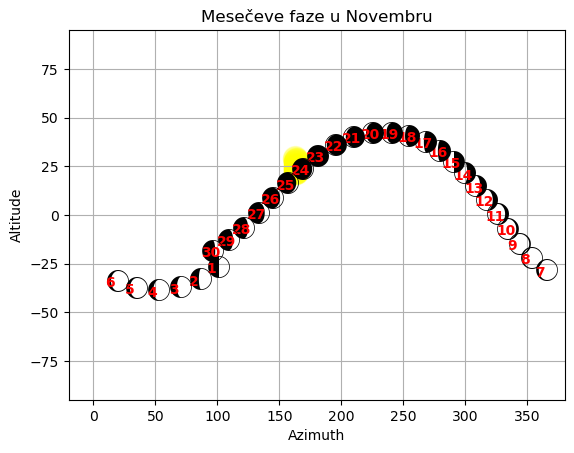

In [3]:
from matplotlib import font_manager

moon_font = font_manager.FontProperties(fname="resources/moon_phases.ttf", size="xx-large")
plt.gca().set_title("Mesečeve faze u Novembru")

bg.date = "2022/11/1 9:20:00"

moon.compute(bg)

prv = ephem.previous_new_moon(bg.date)
nxt = ephem.next_new_moon(bg.date)
#ABCDEFGHIJKLMNOPQRSTUVWXYZ0 = 27
multip = 27/(nxt-prv)

now = bg.date
for i in range(30):
    bg.date = now + ephem.Date(i)
    moon.compute(bg)
    
    prv = ephem.previous_new_moon(bg.date)
    nxt = ephem.next_new_moon(bg.date)
    phase = int((bg.date-prv)*multip)
    
    if phase == 26:
        phase = ord("0")-ord("A")

    plt.annotate(chr(ord("A") + phase), (np.rad2deg(moon.az), np.rad2deg(moon.alt)), fontproperties=moon_font)
    plt.annotate(str(i+1), (np.rad2deg(moon.az), np.rad2deg(moon.alt)+3), color="red", weight="bold")
    
    sun.compute(bg)
    plt.scatter(np.rad2deg(sun.az), np.rad2deg(sun.alt), s=300, color="yellow", alpha=0.2)
    
plt.xlim([-20, 380])
plt.xlabel("Azimuth")
plt.ylim([-95, 95])
plt.ylabel("Altitude")
plt.grid()
plt.show()

## POMRAČENJA

**1. Napisati kod koji računa datume i vremena pomračenja Sunca u narednih 10 godina.**

Spisak svih pomračenja možemo naći na [NASA sajtu](https://eclipse.gsfc.nasa.gov/eclipse.html), i tako proveriti tačnost rezultata. 

Pomračenja Sunca ćemo računati tako što ćemo proveravati da li je ugaono rastojanje Sunca i Meseca manje od zbira njihovih poluprečnika. Ako jeste, Mesec će sigurno bar malo zaklanjati Sunce.

Ovaj postupak ponavljamo na svakih 20 minuta tokom 10 godina, a kada nađemo pomračenje slobodno idemo skoro ceo jedan dan unapred.

In [ ]:
now = datetime.datetime.now()
end = now + datetime.timedelta(days=10*365)

sun = ephem.Sun()
moon = ephem.Moon()
bg = ephem.Observer()
bg.lat = "44.83"
bg.lon = "20.5"


while now <= end:
    bg.date = now
    moon.compute(bg)
    sun.compute(bg)

    separation = np.rad2deg(abs(float(ephem.separation(moon, sun))))

    if separation < abs(sun.size + moon.size)/7200:
        print(now.strftime("%d:%m:%Y, %H:%M:%S"))
        now += datetime.timedelta(hours = 22)
        
    else:
        now += datetime.timedelta(minutes = 20)


14:10:2023, 18:12:48
08:04:2024, 18:52:48
29:03:2025, 11:12:48
12:08:2026, 17:32:48
02:08:2027, 08:32:48
26:01:2028, 15:52:48


**2. Napisati kod koji računa datume i vremena pomračenja Meseca u narednih 10 godina.**

Pomračenja Meseca računamo slično kao i pomračenja Sunca, sa tim da ih moramo proveravati češće, i da će se pomračenje dogoditi ukoliko je geocentrična separacija ova dva tela bliska 180 stepeni, a ne nuli kao u prošlom zadatku. 

In [ ]:
now = datetime.datetime.now()
end = now + datetime.timedelta(days=10*365)

while now <= end:
    bg.date = now
    moon.compute(bg)
    sun.compute(bg)

    separation = np.rad2deg(abs(float(ephem.separation(moon, sun)) - np.deg2rad(180)))
    
    if separation < (abs(sun.size + moon.size)/7200 + np.rad2deg(np.arctan(4.258750456e-5/moon.earth_distance))):
        #print(moon.earth_distance)
        print(now.strftime("%d:%m:%Y, %H:%M:%S"))
        now += datetime.timedelta(hours = 22)
        
    else:
        now += datetime.timedelta(minutes = 5)
    

**3. Napisati kod koji računa sve tranzite Venere preko Sunca u periodu od 1630 do 2200. godine.**

Ovaj zadatak je sličan zadatku koji se ticao pomračenja Sunca, s tim da možemo ređe proveravati pomračenja, i preskakati veće vremenske periode kada ih pronađemo. 

Još jedan dodatni uslov je to da nam se Venera može naći i ispred i iza Sunca, što kod Meseca nije bilo moguće. Tranzit Venere preko Sunca će se dogoditi samo ako je Venera bliža nego Sunce.

In [ ]:
now = datetime.datetime.strptime("1630", "%Y")
end = datetime.datetime.strptime("2200", "%Y")

venus = ephem.Venus()

while now <= end:
    bg.date = now
    sun.compute(bg)
    venus.compute(bg)
    
    separation = np.rad2deg(abs(ephem.separation(venus, sun)))
    
    if separation < abs(sun.size + venus.size)/7200 and venus.earth_distance < sun.earth_distance:
        print(now.strftime("%d:%m:%Y, %H:%M:%S"))
        now += datetime.timedelta(days = 365*7)
        
    else:
        now += datetime.timedelta(hours = 2)